In [2]:
import torch
import triton
import triton.language as tl

from flashattn_fwd import _attn_fwd
from flashattn_bwd import _attn_bwd_prep, _attn_bwd

DEVICE = torch.device("cuda:0")

=== GPU Specs ===
Name: NVIDIA RTX A6000
SM Count: 84
Device Memory: 49139 MB
Compute Capability: 8.6

=== Running Sequence Length Benchmark ===


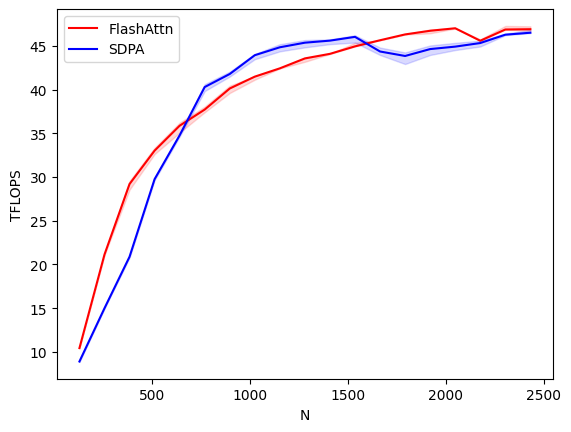

flash-attention-forward:
         N  FlashAttn       SDPA
0    128.0  10.435669   8.904348
1    256.0  21.140645  14.996796
2    384.0  29.199208  20.886118
3    512.0  33.015617  29.755278
4    640.0  35.866901  34.770798
5    768.0  37.712531  40.288525
6    896.0  40.120738  41.780693
7   1024.0  41.478482  43.928613
8   1152.0  42.426598  44.834595
9   1280.0  43.562882  45.359911
10  1408.0  44.084145  45.594850
11  1536.0  44.938972  46.026064
12  1664.0  45.638636  44.352010
13  1792.0  46.305177  43.839781
14  1920.0  46.722433  44.629542
15  2048.0  47.010803  44.909300
16  2176.0  45.581209  45.319447
17  2304.0  46.867222  46.274821
18  2432.0  46.900516  46.498616


In [8]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[128 * i for i in range(1, 20)],
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['FlashAttn', 'SDPA'],
        styles=[('red', '-'), ('blue', '-')],
        ylabel='TFLOPS',
        plot_name='flash-attention-forward',
        args={'Z': 100, 'H': 8, 'HEAD_DIM': 128, 'dtype': torch.float16},
    ))
def bench_flash_attention(Z, H, N, HEAD_DIM, dtype, provider, device=DEVICE):
    torch.manual_seed(42)
    scale = 1.0 / (HEAD_DIM ** 0.5)
    
    Q = torch.randn(Z, H, N, HEAD_DIM, dtype=dtype, device=device, requires_grad=False)
    K = torch.randn(Z, H, N, HEAD_DIM, dtype=dtype, device=device, requires_grad=False)
    V = torch.randn(Z, H, N, HEAD_DIM, dtype=dtype, device=device, requires_grad=False)
    
    quantiles = [0.5, 0.2, 0.8]

    def triton_fwd():
        Q_flat = Q.reshape(Z * H * N, HEAD_DIM).contiguous()
        K_flat = K.reshape(Z * H * N, HEAD_DIM).contiguous()
        V_flat = V.reshape(Z * H * N, HEAD_DIM).contiguous()
        O = torch.empty_like(Q_flat)
        B = torch.empty(Z * H * N, dtype=torch.float32, device=DEVICE)
        grid = lambda meta: (triton.cdiv(N, meta['BLOCK_MAJOR']), Z * H)
        
        _attn_fwd[grid](
            scale, B, Z, H, N,
            Q_flat, K_flat, V_flat, O,
            HEAD_DIM=HEAD_DIM
        )
        return O.reshape(Z, H, N, HEAD_DIM)

    def torch_fwd():
        return torch.nn.functional.scaled_dot_product_attention(
            Q, K, V, attn_mask=None, dropout_p=0.0, is_causal=True
        )

    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(triton_fwd, quantiles=quantiles, rep=100)
    elif provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(torch_fwd, quantiles=quantiles, rep=100)
    
    # 2 * batch * heads * seq_len^2 * head_dim (QK^T + softmax + AV)
    # for causal attention, roughly half the operations
    flops_per_attention = 2.0 * Z * H * N * N * HEAD_DIM * 0.5  # 0.5 for causal
    tflops = flops_per_attention * 1e-12 / (ms * 1e-3)
    tflops_min = flops_per_attention * 1e-12 / (max_ms * 1e-3)  
    tflops_max = flops_per_attention * 1e-12 / (min_ms * 1e-3)
    
    return tflops, tflops_min, tflops_max

if __name__ == "__main__":
    print("=== GPU Specs ===")
    specs = torch.cuda.get_device_properties(DEVICE)
    print(f"Name: {specs.name}")
    print(f"SM Count: {specs.multi_processor_count}")
    print(f"Device Memory: {specs.total_memory // (1024 ** 2)} MB")
    print(f"Compute Capability: {specs.major}.{specs.minor}")
    
    print("\n=== Running Sequence Length Benchmark ===")
    bench_flash_attention.run(show_plots=True, print_data=True)

=== GPU Specs ===
Name: NVIDIA RTX A6000
SM Count: 84
Device Memory: 49139 MB
Compute Capability: 8.6

=== Running Sequence Length Benchmark ===


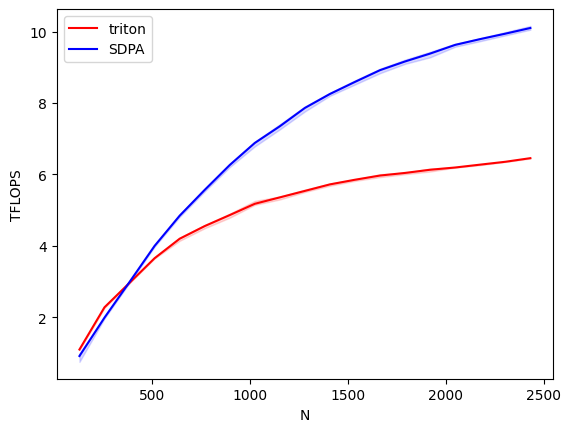

flash-attention-forward:
         N    triton       SDPA
0    128.0  1.092267   0.910222
1    256.0  2.275555   1.985939
2    384.0  2.960964   2.984939
3    512.0  3.651031   3.996098
4    640.0  4.196721   4.841608
5    768.0  4.551111   5.564377
6    896.0  4.859661   6.262215
7   1024.0  5.175597   6.880420
8   1152.0  5.355545   7.348306
9   1280.0  5.537006   7.861804
10  1408.0  5.719746   8.253389
11  1536.0  5.849978   8.591755
12  1664.0  5.967448   8.920413
13  1792.0  6.040752   9.164566
14  1920.0  6.129697   9.384928
15  2048.0  6.192683   9.628797
16  2176.0  6.273153   9.791100
17  2304.0  6.352819   9.942716
18  2432.0  6.454195  10.101835


In [3]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[128 * i for i in range(1, 20)],
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=['triton', 'SDPA'],
        styles=[('red', '-'), ('blue', '-')],
        ylabel='TFLOPS',
        plot_name='flash-attention-forward',
        args={'Z': 5, 'H': 8, 'HEAD_DIM': 128, 'dtype': torch.float16},
    ))
def bench_flash_attention(Z, H, N, HEAD_DIM, dtype, provider, device=DEVICE):
    torch.manual_seed(42)
    scale = 1.0 / (HEAD_DIM ** 0.5)
    
    Q = torch.randn(Z, H, N, HEAD_DIM, dtype=dtype, device=device, requires_grad=False)
    K = torch.randn(Z, H, N, HEAD_DIM, dtype=dtype, device=device, requires_grad=False)
    V = torch.randn(Z, H, N, HEAD_DIM, dtype=dtype, device=device, requires_grad=False)
    
    quantiles = [0.5, 0.2, 0.8]

    def triton_bwd():
        Q_ = Q.detach().clone().reshape(Z * H * N, HEAD_DIM).contiguous()
        K_ = K.detach().clone().reshape(Z * H * N, HEAD_DIM).contiguous()
        V_ = V.detach().clone().reshape(Z * H * N, HEAD_DIM).contiguous()
        DO_ = torch.randn_like(Q_)

        O_ = torch.empty_like(Q_)
        B_ = torch.empty(Z * H * N, dtype=torch.float32, device=device)
        Delta_ = torch.empty(Z * H * N, dtype=torch.float16, device=device)
        DQ_ = torch.empty_like(Q_)
        DK_ = torch.empty_like(K_)
        DV_ = torch.empty_like(V_)

        grid = lambda meta: (triton.cdiv(N, meta['BLOCK_MAJOR']), Z * H)

        _attn_fwd[grid](
            scale, B_, Z, H, N,
            Q_, K_, V_, O_,
            HEAD_DIM=HEAD_DIM
        )

        _attn_bwd_prep[grid](
            O_, DO_,
            Delta_,
            Z, H, N,
            HEAD_DIM=HEAD_DIM
        )

        _attn_bwd[grid](
            Q_, K_, V_, scale,
            DO_, DQ_, DK_, DV_,
            B_, Delta_,
            Z, H, N,
            HEAD_DIM=HEAD_DIM
        )

    def torch_bwd():
        Q_ref = Q.detach().clone().requires_grad_()
        K_ref = K.detach().clone().requires_grad_()
        V_ref = V.detach().clone().requires_grad_()
        DO_ref = torch.randn_like(Q_ref)

        O_ref = torch.nn.functional.scaled_dot_product_attention(
            Q_ref, K_ref, V_ref, attn_mask=None, dropout_p=0.0, is_causal=True
        )
        O_ref.backward(DO_ref)

    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(triton_bwd, quantiles=quantiles, rep=100)
    elif provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(torch_bwd, quantiles=quantiles, rep=100)
    
    # batch * heads * seq_len^2 * head_dim (EFFECTIVE FLOPS) 
    flops_per_attention = Z * H * N * N * HEAD_DIM
    tflops = flops_per_attention * 1e-12 / (ms * 1e-3)
    tflops_min = flops_per_attention * 1e-12 / (max_ms * 1e-3)  
    tflops_max = flops_per_attention * 1e-12 / (min_ms * 1e-3)
    
    return tflops, tflops_min, tflops_max

if __name__ == "__main__":
    print("=== GPU Specs ===")
    specs = torch.cuda.get_device_properties(DEVICE)
    print(f"Name: {specs.name}")
    print(f"SM Count: {specs.multi_processor_count}")
    print(f"Device Memory: {specs.total_memory // (1024 ** 2)} MB")
    print(f"Compute Capability: {specs.major}.{specs.minor}")
    
    print("\n=== Running Sequence Length Benchmark ===")
    bench_flash_attention.run(show_plots=True, print_data=True)

In [4]:
# for debugging bwd kernel

import math

def test_attn_bwd():
    torch.manual_seed(0)

    DEVICE = torch.device("cuda:0")

    Z, H, N, HEAD_DIM = 2, 3, 512, 128
    scale = 1.0 / math.sqrt(HEAD_DIM)

    # Inputs
    Q = torch.randn(Z, H, N, HEAD_DIM, dtype=torch.float16, device=DEVICE).contiguous()
    K = torch.randn(Z, H, N, HEAD_DIM, dtype=torch.float16, device=DEVICE).contiguous()
    V = torch.randn(Z, H, N, HEAD_DIM, dtype=torch.float16, device=DEVICE).contiguous()
    DO = torch.randn(Z, H, N, HEAD_DIM, dtype=torch.float16, device=DEVICE).contiguous()

    # Reference output using PyTorch
    Q_ref = Q.clone().detach().requires_grad_()
    K_ref = K.clone().detach().requires_grad_()
    V_ref = V.clone().detach().requires_grad_()

    O_ref = torch.nn.functional.scaled_dot_product_attention(
        Q_ref, K_ref, V_ref, attn_mask=None, dropout_p=0.0, is_causal=True
    ).to(torch.float16)
    O_ref.backward(DO)
    O_ref = O_ref.reshape(Z * H * N, HEAD_DIM)

    # Triton backward tensors (flattened)
    Q_flat = Q.clone().detach().reshape(Z * H * N, HEAD_DIM).contiguous()
    K_flat = K.clone().detach().reshape(Z * H * N, HEAD_DIM).contiguous()
    V_flat = V.clone().detach().reshape(Z * H * N, HEAD_DIM).contiguous()
    DO_flat = DO.clone().detach().reshape(Z * H * N, HEAD_DIM).contiguous()
    O = torch.zeros_like(Q_flat)
    Delta = torch.zeros((Z * H * N), dtype=torch.float16, device=DEVICE).contiguous()
    B = torch.ones((Z * H * N), dtype=torch.float32, device=DEVICE).contiguous()
    DQ_flat = torch.empty_like(Q_flat)
    DK_flat = torch.empty_like(K_flat)
    DV_flat = torch.empty_like(V_flat)

    grid = lambda meta: (triton.cdiv(N, meta['BLOCK_MAJOR']), Z * H)

    _attn_fwd[grid](
        scale, B, Z, H, N,
        Q_flat, K_flat, V_flat, O,
        HEAD_DIM#, BLOCK_MAJOR, BLOCK_MINOR
    )
    
    #A = torch.matmul(Q_flat, K_flat.T) * scale  
    #torch.testing.assert_close(O, O_ref, atol=1e-2, rtol=1e-2)
    #mask = torch.triu(torch.ones_like(A), diagonal=1).bool()
    #A_masked = A.masked_fill(mask, float('-inf'))
    #max_A, _ = A_masked.max(dim=1, keepdim=True)
    #log2sumexp = (max_A  * 1.4426950408889634 + (A_masked - max_A).exp().sum(dim=1, keepdim=True).log2()).squeeze(1).to(torch.float32)
    #torch.testing.assert_close(B, log2sumexp, atol=1e-2, rtol=1e-2)

    _attn_bwd_prep[grid](
        O, DO_flat,
        Delta,
        Z, H, N,
        HEAD_DIM=HEAD_DIM
    )

    #Delta_ref = (O * DO_flat).sum(dim=1)
    #torch.testing.assert_close(Delta, Delta_ref, atol=1e-2, rtol=1e-2)

    # Step 2: Launch _attn_bwd
    _attn_bwd[grid](
        Q_flat, K_flat, V_flat, scale,
        DO_flat, DQ_flat, DK_flat, DV_flat,
        B, Delta,
        Z, H, N,
        HEAD_DIM=HEAD_DIM
    )

    #D = torch.nn.functional.softmax(A_masked, dim = -1)
    #DDT = torch.matmul(V_flat, DO_flat.T)
    #DAT = D.T * (DDT - Delta[None, :])
    #DK = torch.matmul(DAT, Q_flat)
    #print(DK_flat - DK * scale)
    #print(DQ_flat - Q_ref.grad)
    #print(Delta)
    #print(DK)
    #print(DK * scale - DK_flat)
    #print(DK * scale - K_ref.grad)


    torch.testing.assert_close(DQ_flat, Q_ref.grad.reshape(Z * H * N, HEAD_DIM), atol=1e-2, rtol=1e-2)
    torch.testing.assert_close(DK_flat, K_ref.grad.reshape(Z * H * N, HEAD_DIM), atol=1e-2, rtol=1e-2)
    torch.testing.assert_close(DV_flat, V_ref.grad.reshape(Z * H * N, HEAD_DIM), atol=1e-2, rtol=1e-2)

    print("Test passed.")

    #AT = torch.matmul(K_flat.T, Q_flat) * scale
    #DT = torch.nn.functional.softmax(AT, dim = -1)
    #print(DT)
    #print(DV_flat - V_ref.grad.reshape(Z * H * N, HEAD_DIM))
    
    #print(D.T, DO_flat)
    #print(torch.matmul(D.T, DO_flat) - DV_flat)
    #print(V_ref.grad.reshape(Z * H * N, HEAD_DIM))

test_attn_bwd()

Test passed.
